# Neural ODEs

In [10]:
from IPython.display import HTML, set_matplotlib_formats

set_matplotlib_formats('pdf', 'svg')
css_style = open('../../../_static/custom_style.css', 'r').read()
HTML(f'<style>{css_style}</style>')

Let $\mathbf{z} \in \mathbb{R}^N$ whose dynamics evolve according to the [ordinary differential equation](https://mathworld.wolfram.com/OrdinaryDifferentialEquation.html)

$$ \frac{d\mathbf{z}}{dt} = \mathbf{f}(\mathbf{z}, \mathbf{\theta}, t), $$

where $\mathbf{\theta} \in \mathbb{R}^P$ and let $L : \mathbb{R}^N \to \mathbb{R}$. We want to compute the derivatives of the loss $L$ with respect to the parameters $\mathbf{\theta}$. One way to do this would be to solve numerically for $\mathbf{z}(t_1)$ and then backpropagate through the numerical integration routine. Numerical integration routines like [Runge Kutta](https://mathworld.wolfram.com/Runge-KuttaMethod.html) involve only summations and evaluations of $\mathbf{f}$, so we could implement such an algorithm using an automatic differentiation library and then backpropagate. However, this requires that we retain the intermediate values of $\mathbf{z}(t)$ that the solver used during integration, which would incur a memory cost of $\mathcal{O}(T)$ where $T = t_1 - t_0$.

The Neural ODE paper proposes first solving the ODE foward from $t_0$ to $t_1$, and then setting up a new differential equation which when solved backwards from $t_1$ to $t_0$ will give us the derivatives of $L$ w.r.t. $\mathbf{\theta}.$ This has two convenient implications. First, we do not need to retain the intermediate $\mathbf{z}$ in memory, because we won't be backpropagating through the ODE solver. Second, we can use off-the-shelf numerical integrators to solve this new backward equation. So there is no need to implement a new solver that supports automatic differentiation.

In order to set up the backward equation, two key ideas are used. First, we can set up a differential equation for $d L / d\mathbf{z}$. Second, we can append $\mathbf{\theta}$ to $\mathbf{z}$, to obtain the augmented state $\mathbf{z}_{aug}$. Then the ODE obeyed by $d L / d\mathbf{z}_{aug} = \left[d L / d\mathbf{z}, d L / d\mathbf{\theta}\right]$ will describe the evolution of $d L / d\mathbf{\theta}$ inside it. We can solve this ODE to obtain $d L / d\mathbf{\theta}$.

Let's look at this in detail. First, we define the adjoint, which we will use to set up the backward equation.

<div class='definition'>

**Definition (Adjoint)** Given $\mathbf{z}(t) \in \mathbb{R}^N$ for $t \in [t_0, t_1]$ and a function $L : \mathbb{R}^N \to \mathbb{R}$, the adjoint is defined as
    
$$ \mathbf{a}(t) = \frac{\partial L}{\partial \mathbf{z}(t)}. $$
    
</div>
<br>

As advertised, the adjoint itself obeys a differential equation, stated and proved below.

<div class='theorem'>

**Result (Differential equation of the adjoint)** Given an ODE of the form
    
$$\frac{d\mathbf{z}}{dt} = \mathbf{f}(\mathbf{z}, \mathbf{\theta}, t),$$
    
the adjoint $\mathbf{a}(t)$ obeys the differential equation

$$ \frac{d \mathbf{a}}{dt} = - \frac{\partial \mathbf{f}}{\partial \mathbf{z}} \mathbf{a},~~\text{ where } \left(\frac{\partial \mathbf{f}}{\partial \mathbf{z}}\right)_{ij} = \frac{\partial f_j}{\partial z_i}. $$
    
</div>
<br>


<details class="proof">
<summary>Proof: Differential equation of the adjoint</summary>

<div>
    
Starting from the relation
    
$$\begin{align}
\mathbf{a}(t) &= \frac{\partial \mathbf{z}(t + \epsilon)}{\partial \mathbf{z}(t)} \frac{d L}{d \mathbf{z}(t + \epsilon)} \\
&= \frac{\partial \mathbf{z}(t + \epsilon)}{\partial \mathbf{z}(t)} \mathbf{a}(t + \epsilon),
\end{align}$$
    
we substitute the following identity
    
$$ \begin{align}
\frac{\partial \mathbf{z}(t + \epsilon)}{\partial \mathbf{z}(t)} &= \frac{\partial}{\partial \mathbf{z}} \int_t^{t + \epsilon} \mathbf{f}(\mathbf{z}, t) dt \\
&= \mathbf{I} + \epsilon \frac{\partial \mathbf{f}}{\partial \mathbf{z}} + \mathcal{O}(\epsilon^2),
\end{align}$$
    
to obtain the relation
    
$$\begin{align}
\mathbf{a}(t) = \left[ \mathbf{I} + \epsilon \frac{\partial \mathbf{f}}{\partial \mathbf{z}} + \mathcal{O}(\epsilon^2) \right] \mathbf{a}(t + \epsilon),
\end{align}$$
    
Now we write the change in $\mathbf{a}$ from $t$ to $t + \epsilon$ as
    
$$\begin{align}
\mathbf{a}(t + \epsilon) - \mathbf{a}(t) = \left[ - \epsilon \frac{\partial \mathbf{f}}{\partial \mathbf{z}} + \mathcal{O}(\epsilon^2) \right] \mathbf{a}(t + \epsilon).
\end{align}$$
    
Dividing by $\epsilon$ and taking the limit $\epsilon \to 0$ we arrive at
    
$$\begin{align}
\frac{d \mathbf{a}}{d t} = - \frac{\partial \mathbf{f}}{\partial \mathbf{z}} \mathbf{a}.
\end{align}$$
 
</div>

</details>
<br>

Now if we integrate the differential equation of the adjoint we obtain

$$ \begin{align}
\frac{d L}{d \mathbf{z}(t)} = \mathbf{a}(T) + \int_t^T \frac{d \mathbf{f}}{d \mathbf{z}} \mathbf{a}~dt.
\end{align}$$

It would be great if in addition to $\frac{d L}{d \mathbf{z}(t)}$ we could also compute $\frac{d L}{d \mathbf{\theta}}$ in a similar way. This is where the second piece of insight comes in. If we append $\mathbf{\theta}$ to the state vector $\mathbf{z}$ to obtain the augmented state

$$ \begin{align}
\mathbf{z}_{aug} = \begin{bmatrix}\mathbf{z} \\ \mathbf{\theta} \end{bmatrix},
\end{align}$$

and let this evolve accoding to the ODE

$$ \begin{align}
\frac{d \mathbf{z}_{aug}}{d t} = \mathbf{f}_{aug}(\mathbf{z}_{aug}, \mathbf{\theta}, t),~~\text{ where }~~\mathbf{f}_{aug} = \begin{bmatrix}\mathbf{f} \\ 0 \end{bmatrix},
\end{align}$$

then the augmented adjoint obeys

$$ \frac{d \mathbf{a}_{aug}}{dt} = - \frac{\partial \mathbf{f}_{aug}}{\partial \mathbf{z}_{aug}} \mathbf{a}_{aug}. $$

We can then integrate this equation in precisely the same way as above to obtain

$$ \begin{align}
\frac{d L}{d \mathbf{z}_{aug}(t)} \equiv \left[\frac{d L}{d \mathbf{z}(t)}, \frac{d L}{d \mathbf{\theta}}\right] = \mathbf{a}_{aug}(T) + \int_t^T \frac{d \mathbf{f}_{aug}}{d \mathbf{z}_{aug}} \mathbf{a}_{aug}~dt,
\end{align}$$

arriving at the derivative $\frac{d L}{d \mathbf{\theta}}$ which are after. In practice, when solving backwards for the above intetgral, we will require $\mathbf{z}$ as well. We will therefore need to solve for the differential equation


<div class='definition'>

**Definition (ODE gradients with the adjoint sensitivity method)** Given $\mathbf{z}(t) \in \mathbb{R}^N, t \in [t_0, t_1]$ evolving according to 
  
$$ \frac{d\mathbf{z}}{dt} = \mathbf{f}(\mathbf{z}, \mathbf{\theta}, t), $$
    
where $\mathbf{\theta} \in \mathbb{R}^P$ and let $L : \mathbb{R}^N \to \mathbb{R}$, with the initial condition $\mathbf{z}_0$ and a function $L : \mathbb{R}^N \to \mathbb{R}$, the adjoint sensitivity method computes the derivatives of $L$ w.r.t. $\mathbf{\theta}$ in two steps:
    
1. Solve the above ODE for $\mathbf{z}(t_1) = \mathbf{z}_1$ and compute $\mathbf{a}(t_1) = \mathbf{a}_1$.
2. Solve the following ODE from time $t = t_1$ to $t = t_0$
    
$$\begin{align}
\frac{d}{d t} \begin{bmatrix} \mathbf{z} \\ \frac{\partial L}{\partial \mathbf{z}} \\ \frac{\partial L}{\partial \mathbf{\theta}} \end{bmatrix} = \begin{bmatrix} \mathbf{f} \\ - \frac{\partial \mathbf{f}}{\partial \mathbf{z}}\mathbf{a} \\ - \frac{\partial \mathbf{f}}{\partial \mathbf{\theta}}\mathbf{a} \end{bmatrix}, \text{ with init. cond. } \left[\mathbf{z}_1, \mathbf{a}_1, \mathbf{\theta} \right].
\end{align}$$
    
</div>
<br>



<details class="proof">
<summary>Derivation: ODE gradients with the adjoint sensitivity method</summary>
    
Here we derive the ODE in the second step of the above algorithm. The matrix $\partial \mathbf{f}_{aug} / \partial \mathbf{z}_{aug}$ in the expression
    
$$ \frac{d \mathbf{a}_{aug}}{dt} = - \frac{\partial \mathbf{f}_{aug}}{\partial \mathbf{z}_{aug}} \mathbf{a}_{aug}. $$

is given by the following expression 

$$ \frac{\partial \mathbf{f}_{aug}}{\partial \mathbf{z}_{aug}} = \begin{bmatrix}
\frac{d\mathbf{f}}{d\mathbf{z}} & \mathbf{0}  \\
\frac{d\mathbf{f}}{d\mathbf{\theta}} & \mathbf{0}  \end{bmatrix}.$$

Hence, the augmented adjoint obeys

$$ \begin{align}
\frac{d \mathbf{a}_{aug}}{d t} = \frac{d}{d t} \begin{bmatrix} \frac{\partial L}{\partial \mathbf{z}} \\ \frac{\partial L}{\partial \mathbf{\theta}} \end{bmatrix} = \begin{bmatrix} - \frac{\partial \mathbf{f}}{\partial \mathbf{z}}\mathbf{a} \\ - \frac{\partial \mathbf{f}}{\partial \mathbf{\theta}}\mathbf{a} \end{bmatrix}.
\end{align}$$

In order to evaluate the expression on the RHS at any time $t$ during the backward solve, we will need to know $\mathbf{z}(t)$. We therefore explicitly include the evolution of $\mathbf{z}$ in the ODE, arriving at the ODE problem
    
$$\begin{align}
\frac{d}{d t} \begin{bmatrix} \mathbf{z} \\ \frac{\partial L}{\partial \mathbf{z}} \\ \frac{\partial L}{\partial \mathbf{\theta}} \end{bmatrix} = \begin{bmatrix} \mathbf{f} \\ - \frac{\partial \mathbf{f}}{\partial \mathbf{z}}\mathbf{a} \\ - \frac{\partial \mathbf{f}}{\partial \mathbf{\theta}}\mathbf{a} \end{bmatrix}, \text{ with init. cond. } \left[\mathbf{z}_1, \mathbf{a}_1, \mathbf{\theta} \right].
\end{align}$$

</details>
<br>

In [ ]:
import numpy as np
from scipy.integrate import ode as ODE
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_probability as tfp

tfd = tfp.distributions

In [2]:
class TransitionDynamics(tf.Module):
    
    def __init__(self, hidden_size, state_size):
        
        self.W1 = np.random.normal(size=(hidden_size, state_size), loc=0, scale=state_size**-0.5)
        self.b1 = np.random.normal(size=(hidden_size,))
        
        self.W2 = np.random.normal(size=(state_size, hidden_size), loc=0, scale=hidden_size**-0.5)
        self.b2 = np.random.normal(size=(state_size,))
        
    
    def __call__(self, t, x):
        
        assert len(x.shape) == 1
        
        x = np.dot(self.W1, x)
        x = x + self.b1
        
        x = np.tanh(x)
        
        x = np.dot(self.W2, x)
        x = x + self.b2
        
        return x

In [3]:
np.random.seed(0)

transition_dynamics = TransitionDynamics(hidden_size=3, state_size=2)

x = np.zeros(shape=(2,))

transition_dynamics(None, x)

array([0.41020533, 1.78223644])

In [4]:
np.random.seed(0)

transition_dynamics = TransitionDynamics(hidden_size=3, state_size=2)

y0 = np.array([0., 0.])
t0 = 0.
t1 = 1.

ode = ODE(f=transition_dynamics.__call__).set_integrator('vode')
ode = ode.set_initial_value(y0, t0)

ode.integrate(t1)

array([0.2111968, 1.8093717])

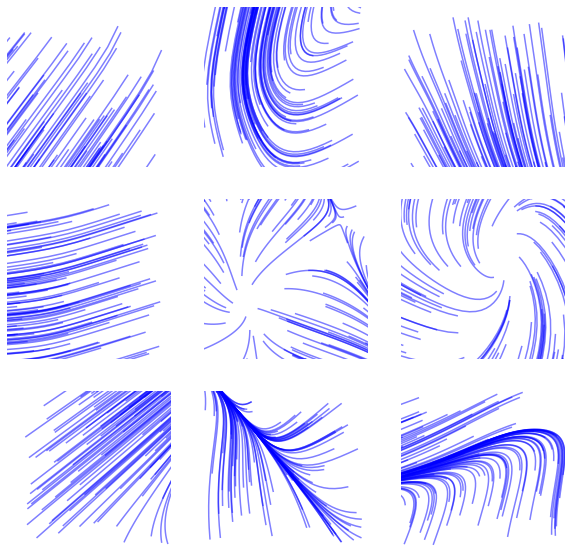

In [5]:
t0 = 0.
t1 = 10.
num_seeds = 100
dt = t1 / 50

plt.figure(figsize=(10, 10))

for i in range(9):

    transition_dynamics = TransitionDynamics(hidden_size=3, state_size=2)

    times = []
    states = []

    for seed in range(num_seeds):

        times.append([])
        states.append([])

        y0 = 4 * (np.random.rand(2) - 0.5)

        ode = ODE(f=transition_dynamics.__call__).set_integrator('vode')
        ode = ode.set_initial_value(y0, t0)

        while ode.successful() and ode.t < t1:

            times[-1].append(ode.t + dt)
            states[-1].append(ode.integrate(ode.t + dt))

    times = np.array(times)
    states = np.array(states)

    plt.subplot(3, 3, i + 1)

    # Plot trajectories
    for seed in range(num_seeds):
        plt.plot(states[seed, :, 0], states[seed, :, 1], color='blue', alpha=0.5)
    
    plt.axis('off')
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    
plt.show()

In [6]:
class NODEModel(tfk.Model):
    
    def __init__(self, hidden_size, state_size, name='transition-dynamics', dtype=tf.float64, **kwargs):
        
        super().__init__(self, name=name, dtype=dtype, **kwargs)
        
        self.state_size = state_size
        
        self.W1 = tf.random.normal(shape=(hidden_size, state_size),
                                   mean=0.,
                                   stddev=state_size**-0.5,
                                   dtype=dtype)
        self.W1 = tf.Variable(self.W1)
        
        self.b1 = tf.random.normal(shape=(hidden_size,),
                                   mean=0.,
                                   stddev=1.,
                                   dtype=dtype)
        self.b1 = tf.Variable(self.b1)
        
        self.W2 = tf.random.normal(shape=(state_size, hidden_size),
                                   mean=0,
                                   stddev=hidden_size**-0.5,
                                   dtype=dtype)
        self.W2 = tf.Variable(self.W2)
        
        self.b2 = tf.random.normal(shape=(state_size,),
                                   mean=0.,
                                   stddev=1.,
                                   dtype=dtype)
        self.b2 = tf.Variable(self.b2)
        
        self.log_noise = tf.convert_to_tensor(np.array(-1.), dtype=dtype)
        self.log_noise = tf.Variable(self.log_noise)
        
    
    def __call__(self, t, x):
        
        assert len(x.shape) == 1
        
        x = tf.tensordot(self.W1, x, axes=(1, 0))
        x = x + self.b1
        
        x = tf.tanh(x)
        
        x = tf.tensordot(self.W2, x, axes=(1, 0))
        x = x + self.b2
        
        return x
    
    
    def df_dx(self, t, x):
        
        with tf.GradientTape() as tape:
            
            tape.watch(x)
            
            f = self.__call__(t, x)
            
        df_dx = tape.gradient(f, x)
        
        return df_dx
    
    
    def df_dtheta(self, t, x):
        
        with tf.GradientTape() as tape:
            
            tape.watch(self.variables)
            
            f = self.__call__(t, x)
            
        df_dtheta = tape.gradient(f, self.variables)
        
        return df_dtheta
    
    
    def loglik(self, x_pred, x_data):
        """
        params x_pred : tf.tensor, predicted state (shape [batch_size, state_size])
        params x_data : tf.tensor, data state (shape [batch_size, state_size])
        """
        
        assert x_pred.shape == x_data.shape
        assert x_pred.shape[-1] == self.state_size
        
        dist = tfd.MultivariateNormalDiag(loc=tf.convert_to_tensor(x_pred, dtype=tf.float32),
                                          scale_identity_multiplier=tf.exp(self.log_noise))
        
        loglik = dist.log_prob(x_data)
        loglik = tf.reduce_sum(loglik)
        
        return loglik
    
    
    def dL_dx(self, x_pred, x_data):
        
        with tf.GradientTape() as tape:
            
            tape.watch(x_pred)
            
            L = - self.loglik(x_pred=x_pred, x_data=x_data)
            
        dL_dx = tape.gradient(L, x_pred)
        
        return dL_dx

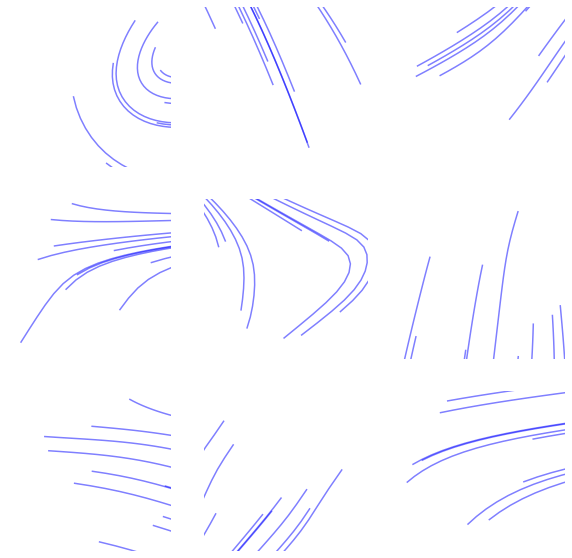

In [69]:
dtype = tf.float32

t0 = 0.
t1 = 10.
num_seeds = 10
dt = t1 / 50

plt.figure(figsize=(10, 10))

for i in range(9):

    node_model = NODEModel(hidden_size=3, state_size=2, dtype=dtype)

    times = []
    states = []

    for seed in range(num_seeds):

        times.append([])
        states.append([])

        y0 = 4 * (np.random.rand(2) - 0.5)
        
        def f(t, x):
            
            x = tf.convert_to_tensor(x, dtype=dtype)
            
            z = node_model(t=t, x=x)
            z = z.numpy()
            
            return z
            
        ode = ODE(f=f).set_integrator('vode')
        ode = ode.set_initial_value(y0, t0)

        while ode.successful() and ode.t < t1:

            times[-1].append(ode.t + dt)
            states[-1].append(ode.integrate(ode.t + dt))

    times = np.array(times)
    states = np.array(states)

    plt.subplot(3, 3, i + 1)

    # Plot trajectories
    for seed in range(num_seeds):
        plt.plot(states[seed, :, 0], states[seed, :, 1], color='blue', alpha=0.5)
    
    plt.axis('off')
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    
plt.show()

In [70]:
x = tf.random.normal(shape=(2,), mean=0., stddev=1., dtype=tf.float32)

node_model.df_dx(t=None, x=x)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.3024133 , 0.10968729], dtype=float32)>

In [71]:
x = tf.random.normal(shape=(2,), mean=0., stddev=1., dtype=tf.float32)

node_model.df_dtheta(t=None, x=x)

[<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[ 0.18246157,  0.10949817],
        [-0.12920731, -0.07753941],
        [ 0.05073825,  0.03044885]], dtype=float32)>,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.18828529, -0.13333128,  0.05235768], dtype=float32)>,
 <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
 array([[0.7109098, 0.6820052, 0.9677044],
        [0.7109098, 0.6820052, 0.9677044]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>,
 None]

In [72]:
dist = tfd.MultivariateNormalDiag(loc=tf.zeros(shape=(10, 1), dtype=tf.float32), scale_identity_multiplier=1.)
dist.log_prob(tf.zeros(shape=(10, 1), dtype=tf.float32))

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-0.9189385, -0.9189385, -0.9189385, -0.9189385, -0.9189385,
       -0.9189385, -0.9189385, -0.9189385, -0.9189385, -0.9189385],
      dtype=float32)>

In [73]:
dist

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[10] event_shape=[1] dtype=float32>

In [74]:
2 * np.log((2 * np.pi) ** -0.5)

-1.8378770664093453

In [75]:
node_model.loglik(x_pred=tf.zeros((5, 2)),
                  x_data=tf.zeros((5, 2)))

<tf.Tensor: shape=(), dtype=float32, numpy=0.8106148>

In [86]:
node_model.dL_dx(x_pred=tf.ones((1, 2)),
                 x_data=tf.zeros((1, 2)))

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[7.3890557, 7.3890557]], dtype=float32)>

In [87]:
1 * np.exp(2)

7.38905609893065

In [93]:
def forwards_solve(model, t0, t1, x0, dt):

    times = []
    states = []
    
    def f(t, x):

        x = tf.convert_to_tensor(x, dtype=dtype)

        x_dot = node_model(t=t, x=x)
        x_dot = x_dot.numpy()

        return x_dot

    ode = ODE(f=f).set_integrator('vode')
    ode = ode.set_initial_value(x0, t0)

    while ode.successful() and ode.t < t1:

        times.append(ode.t + dt)
        states.append(ode.integrate(ode.t + dt))
        
    return times, states

In [96]:
t0 = 0.
t1 = 5.
num_seeds = 10
dt = t1 / 50

node_model = NODEModel(hidden_size=3, state_size=2, dtype=dtype)

x0 = 4 * (np.random.rand(2) - 0.5)

forwards_solve(node_model, t0=t0, t1=t1, x0=x0, dt=dt)

([0.1,
  0.2,
  0.30000000000000004,
  0.4,
  0.5,
  0.6,
  0.7,
  0.7999999999999999,
  0.8999999999999999,
  0.9999999999999999,
  1.0999999999999999,
  1.2,
  1.3,
  1.4000000000000001,
  1.5000000000000002,
  1.6000000000000003,
  1.7000000000000004,
  1.8000000000000005,
  1.9000000000000006,
  2.0000000000000004,
  2.1000000000000005,
  2.2000000000000006,
  2.3000000000000007,
  2.400000000000001,
  2.500000000000001,
  2.600000000000001,
  2.700000000000001,
  2.800000000000001,
  2.9000000000000012,
  3.0000000000000013,
  3.1000000000000014,
  3.2000000000000015,
  3.3000000000000016,
  3.4000000000000017,
  3.5000000000000018,
  3.600000000000002,
  3.700000000000002,
  3.800000000000002,
  3.900000000000002,
  4.000000000000002,
  4.100000000000001,
  4.200000000000001,
  4.300000000000001,
  4.4,
  4.5,
  4.6,
  4.699999999999999,
  4.799999999999999,
  4.899999999999999,
  4.999999999999998,
  5.099999999999998],
 [array([-0.06380813,  0.73876368]),
  array([-0.03333284, 